# Modèle de diffusion

Auteurs : Lisa Giordani, Mouïn Ben Ammar, Yoldoz Tabei, Ilias Harkati (Groupe 6)

Cours : Projet IA (IA321)

Projet : Génération d'images (P13)

Date : Mars 2022

Ce code vise à générer de nouvelles images à partir du dataset CIFAR10. Pour ce faire, on utilise un modèle de diffusion.

Initialisation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

170508288/170498071 [==============================] - 9s 0us/step
data_x shape: (50000, 32, 32, 3)
50000 train samples


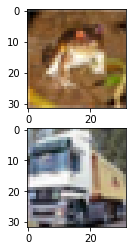

In [3]:
# Paramètres 

num_classes = 10
diffusion_step = 2000
beta1 = 10.e-4
betaT = 0.02
betaStep = (betaT - beta1)/diffusion_step

# Dataset

input_shape = (32, 32, 3)
(data_x, _), _ = keras.datasets.cifar10.load_data()

# Image [0, 1] range

data_x = data_x.astype("float32") / 255
#data_x = np.dot(data_x, np.array([0.2989, 0.5870, 0.1140]))

#data_x = np.expand_dims(data_x, -1)
print("data_x shape:", data_x.shape)
print(data_x.shape[0], "train samples")

f, axarr = plt.subplots(2,1)
axarr[0].imshow(data_x[0,:,:])
axarr[1].imshow(data_x[1,:,:])

# Image [-1, 1] range
data_x = 2 * data_x - 1

Forward process

In [4]:
import math

def calc_alpha_bar(t):
  alphabt = 1
  for i in range(t):
    alphabt = alphabt * (1 - beta1 - i * betaStep)
  return alphabt

def get_alpha_beta(steps):
  alpha_bar = lambda t: math.cos((t/steps + 0.04) / 1.04 * math.pi / 2) ** 2
  max_beta  = 0.999
  betas = []
  for i in range(steps):
      t1 = i
      t2 = (i + 1)
      betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
  return (np.array(betas), alpha_bar)

'''
def generate_sample(steps, x):
  for i in range(steps):
    betat = beta1 + betaStep * i
    mean = 0
    noise = np.random.normal(mean, betat, size=(28,28))
    x = np.sqrt(1 - betat) * x + noise
  return x
'''

def generate_sample_fast(steps, x, alphabar):
  alpha_bar = alphabar(steps)
  noise = np.random.normal(0, 1, size=input_shape)
  x = np.sqrt(alpha_bar) * x + np.sqrt(1-alpha_bar) * noise
  x = np.clip(x,-1,1)
  noise = np.clip(noise,-1,1)
  return noise, x

def make_train_set(quantity, data, alphabar):
  y_train = np.empty(shape=(quantity, *input_shape))
  x_train = np.empty(shape=(quantity, *input_shape))
  #print(x.shape)
  t_i = np.empty(shape=quantity)
  for i in range(quantity):
    t = np.random.randint(0, diffusion_step - 1)
    t_i[i] = t
    y_train[i], x_train[i] = generate_sample_fast(t, data[i], alphabar)
  return y_train, x_train, t_i

Generation sample

13400
x_train shape: (13400, 32, 32, 3)
y train shape: (13400, 32, 32, 3)
t_train shape: (13400,)
t_0:  401.0  t_1:  749.0


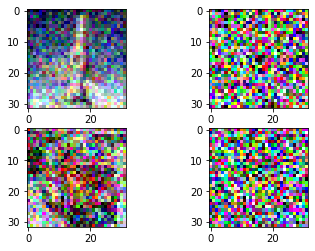

In [11]:
from sklearn.model_selection import train_test_split

betas, abars = get_alpha_beta(diffusion_step)

size_dataset = 20000
y, x, t_i = make_train_set(size_dataset, data_x, abars)
xt_train, xt_test, y_train, y_test = train_test_split(list(zip(x, t_i)), y, test_size=0.33, random_state=15)
print(len(xt_train))
x_train, t_i_train = np.array([i for i, j in xt_train]), np.array([j for i, j in xt_train])
x_test, t_i_test = np.array([i for i, j in xt_test]), np.array([j for i, j in xt_test])

print("x_train shape:", x_train.shape)
print("y train shape:", y_train.shape)
print("t_train shape:", t_i_train.shape)

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow((1+x_train[0,:,:])/2)
axarr[0,1].imshow((1+y_train[0,:,:])/2)
axarr[1,0].imshow((1+x_train[1,:,:])/2)
axarr[1,1].imshow((1+y_train[1,:,:])/2)

print("t_0: ", t_i_train[0], " t_1: ", t_i_train[1])

Model

In [13]:
from tensorflow.keras.layers import Input , Conv2D , MaxPooling2D , Dropout , concatenate , UpSampling2D
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

inputs = Input(input_shape)
conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  
conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

outputs = layers.Conv2D(1, 1, activation = 'sigmoid')(conv9)

model_UNET = keras.Model(inputs = inputs , outputs = outputs,name = 'UNet')

model_UNET.summary()
 

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_48 (Conv2D)             (None, 32, 32, 16)   448         ['input_3[0][0]']                
                                                                                                  
 conv2d_49 (Conv2D)             (None, 32, 32, 16)   2320        ['conv2d_48[0][0]']              
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 16, 16, 16)  0           ['conv2d_49[0][0]']              
                                                                                               

Training

In [14]:
EPOCHS = 20
BATCH_SIZE = 50

model_UNET.compile(optimizer=optimizers.Adam(1e-4) , 
              loss=losses.MeanSquaredError(),
              metrics=[metrics.MeanSquaredError()])

history = model_UNET.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1)

Epoch 1/20
242/242 [==============================] - 155s 635ms/step - loss: 0.7886 - mean_squared_error: 0.7886 - val_loss: 0.7603 - val_mean_squared_error: 0.7603
Epoch 2/20
242/242 [==============================] - 155s 640ms/step - loss: 0.7569 - mean_squared_error: 0.7569 - val_loss: 0.7544 - val_mean_squared_error: 0.7544
Epoch 3/20
242/242 [==============================] - 150s 618ms/step - loss: 0.7511 - mean_squared_error: 0.7511 - val_loss: 0.7486 - val_mean_squared_error: 0.7486
Epoch 4/20
242/242 [==============================] - 150s 620ms/step - loss: 0.7453 - mean_squared_error: 0.7453 - val_loss: 0.7429 - val_mean_squared_error: 0.7429
Epoch 5/20
242/242 [==============================] - 150s 620ms/step - loss: 0.7397 - mean_squared_error: 0.7397 - val_loss: 0.7374 - val_mean_squared_error: 0.7374
Epoch 6/20
242/242 [==============================] - 150s 620ms/step - loss: 0.7342 - mean_squared_error: 0.7342 - val_loss: 0.7319 - val_mean_squared_error: 0.7319
Epoc

Test

In [15]:
score = model_UNET.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.6651464104652405
Test accuracy: 0.6651464104652405


Sampling

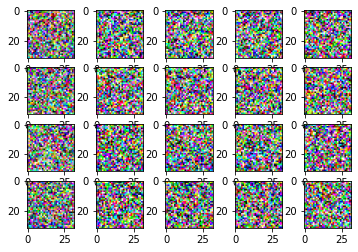

In [17]:
model = model_UNET
sample_size = BATCH_SIZE
sample_shape = (sample_size,*input_shape)
show_step = 3
from_step = diffusion_step//2 - show_step//2

steps = []

def backward(x_T, T, beta_i, abar_i):
  for i in range(T-1, -1,-1):
    alphat = 1 - beta_i[i]
    coef = (1 - alphat) / np.sqrt(1 - abar_i(i)) 
    z = np.random.normal(0, 1, size=sample_shape) if i > 0 else np.zeros(shape=sample_shape)
    x_T = 1./np.sqrt(alphat) * (x_T - coef * model.predict(x_T)) + z
    x_T = np.clip(x_T,-1,1)
    steps.append(x_T)
  return x_T

x_T = np.random.normal(0, 1, size=sample_shape)
x_T = np.clip(x_T,-1,1)
x_T_c = np.copy(x_T)
x_T = backward(x_T, diffusion_step, betas, abars)

#Affichage 'show_sample' samples, X_T ... X_i X_i+1 X_i+2 ... X_0
show_sample = 4
f, axarr = plt.subplots(show_sample, show_step + 2)
for i in range(show_sample):
  axarr[i,0].imshow((1+x_T_c[i,:,:])/2)
  for j in range(show_step):
    axarr[i,j+1].imshow((1+steps[j+from_step][i,:,:])/2)
  axarr[i, show_step+1].imshow((1+x_T[i,:,:])/2)

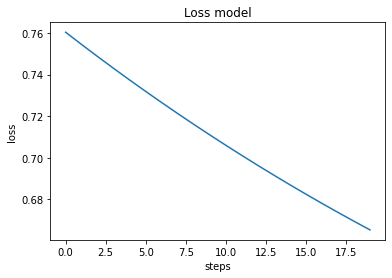

In [19]:
plt.plot(history.history['val_loss'])
plt.title('Loss model')
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()